# Kaggle Challenge

## Retweet Prediction


#### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import ast
from datetime import datetime
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data

#### Data Exploration

In [2]:
train = pd.read_csv('train.csv')
train.shape


(353969, 12)

In [3]:
train.head()

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,[],1646978048000,832509
1,populaire,0,0,86,1016,284,[],[],0,[],1647694288000,1388011
2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,[],1647370048000,63896
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,[],1647256282000,979251
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,[],1647258374000,1040049


In [4]:
train.columns

Index(['text', 'retweets_count', 'favorites_count', 'followers_count',
       'statuses_count', 'friends_count', 'mentions', 'urls', 'verified',
       'hashtags', 'timestamp', 'TweetID'],
      dtype='object')

In [5]:
print("Dataset Shape:", train.shape)
print("\nDataset Info:")
train.info()

Dataset Shape: (353969, 12)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353969 entries, 0 to 353968
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             353969 non-null  object
 1   retweets_count   353969 non-null  int64 
 2   favorites_count  353969 non-null  int64 
 3   followers_count  353969 non-null  int64 
 4   statuses_count   353969 non-null  int64 
 5   friends_count    353969 non-null  int64 
 6   mentions         353969 non-null  object
 7   urls             353969 non-null  object
 8   verified         353969 non-null  int64 
 9   hashtags         353969 non-null  object
 10  timestamp        353969 non-null  int64 
 11  TweetID          353969 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 32.4+ MB


In [6]:
print("\nNumerical Columns Statistics:")
numerical_cols = ['retweets_count', 'favorites_count', 'followers_count',
                 'statuses_count', 'friends_count']
print(train[numerical_cols].describe())


Numerical Columns Statistics:
       retweets_count  favorites_count  followers_count  statuses_count  \
count   353969.000000    353969.000000     3.539690e+05    3.539690e+05   
mean        15.831810        46.655442     2.021548e+04    4.808507e+04   
std        241.986723       852.044385     2.598715e+05    1.133854e+05   
min          0.000000         0.000000     0.000000e+00    1.000000e+00   
25%          0.000000         0.000000     1.600000e+02    2.972000e+03   
50%          1.000000         0.000000     7.260000e+02    1.250100e+04   
75%          3.000000         1.000000     2.283000e+03    4.352200e+04   
max      63674.000000    122591.000000     1.441710e+07    8.183508e+06   

       friends_count  
count  353969.000000  
mean     1459.289003  
std      2502.933271  
min         0.000000  
25%       214.000000  
50%       693.000000  
75%      1804.000000  
max    237269.000000  


In [7]:
# print column names and their unique values
for column in train.columns:
    print(column, train[column].unique())



text ['rt refarcir macron ans nom prépare' 'populaire' 'faut dégager cinglé'
 ... 'eric zemmour français berbère' 'gauchistes dépression pq'
 'algérie emmanuel macron grande histoire amour']
retweets_count [   3    0    2 ... 1003 1718 2555]
favorites_count [   0    1   14 ... 6022 2092 1801]
followers_count [   3682      86    1944 ...   75300 1284079   28304]
statuses_count [ 453535    1016   28234 ... 1555348  111534  150460]
friends_count [ 3628   284  1995 ... 14888 32135  8587]
mentions ['[]']
urls ['[]' "['https://t.co/rytlted08g']" "['https://t.co/jcafxdwm0w']" ...
 "['https://t.co/qd6x2lo3li']" "['https://t.co/8n5jrme29f']"
 "['https://t.co/pma33zhslx']"]
verified [0 1]
hashtags ['[]' "['aec2023', 'presidentielle2022', 'melenchon']"
 "['commejaime', 'hidalgo', 'presidentielle2022']" ...
 "['boyer', 'fillon']" "['camus', 'zemmour', 'poutine']"
 "['ilsvousdisent', 'lacorse']"]
timestamp [1646978048000 1647694288000 1647370048000 ... 1647438153000 1646987195000
 1647602843000]
Tw

> Looks like mentions column is empty. let's drop it.


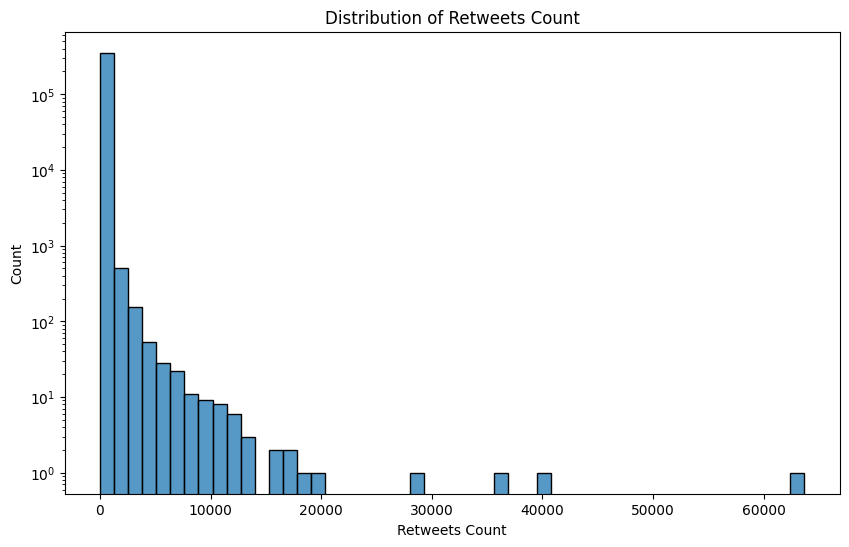

In [8]:
# Show target distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=train, x='retweets_count', bins=50)
plt.title('Distribution of Retweets Count')
plt.xlabel('Retweets Count')
plt.yscale('log')
plt.show()

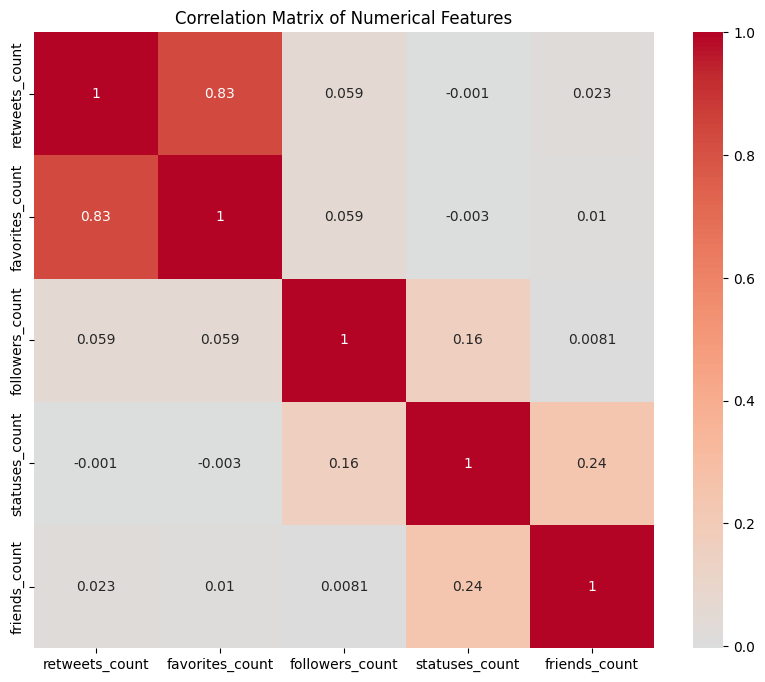

In [9]:
# Let's see the correlation between numerical features
plt.figure(figsize=(10, 8))
correlation_matrix = train[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

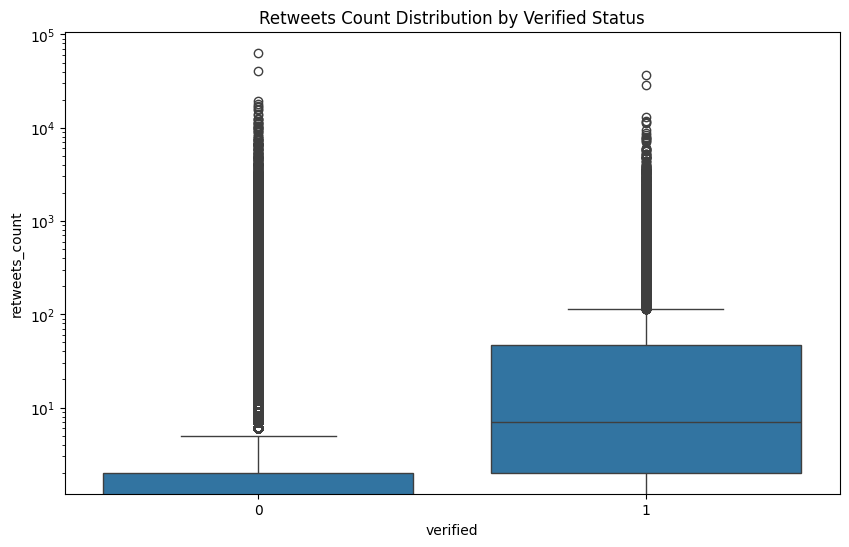

In [10]:
# Check verified accounts relationship with retweets count
plt.figure(figsize=(10, 6))
sns.boxplot(data=train, x='verified', y='retweets_count')
plt.title('Retweets Count Distribution by Verified Status')
plt.yscale('log')
plt.show()

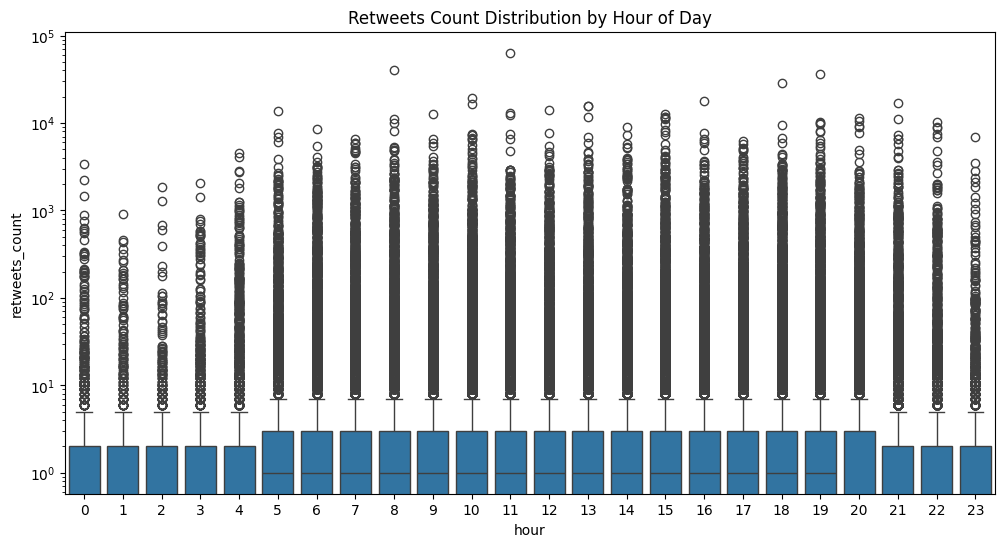

In [11]:
# Time analysis
train['timestamp'] = pd.to_datetime(train['timestamp'], unit='ms')
train['hour'] = train['timestamp'].dt.hour
train['day_of_week'] = train['timestamp'].dt.dayofweek

# Retweets by hour of day
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x='hour', y='retweets_count')
plt.title('Retweets Count Distribution by Hour of Day')
plt.yscale('log')
plt.show()


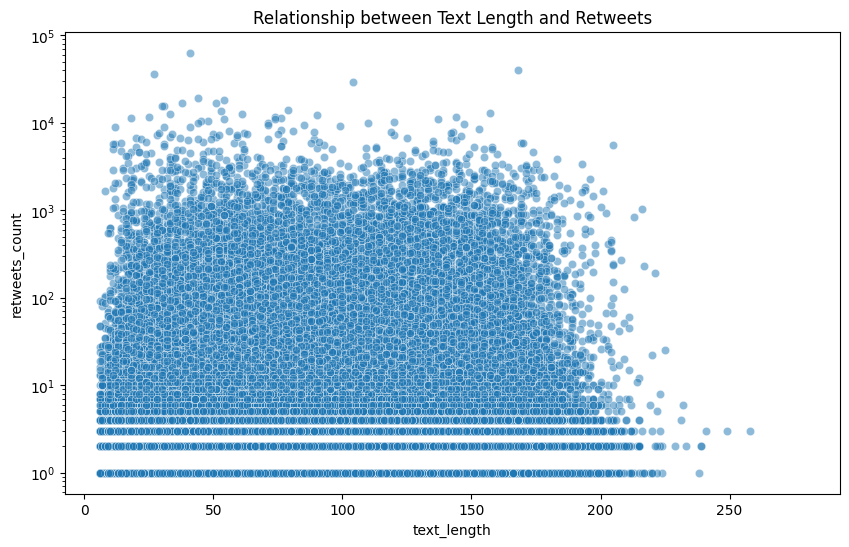

In [12]:
# Analysis of text features
train['text_length'] = train['text'].str.len()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=train, x='text_length', y='retweets_count', alpha=0.5)
plt.title('Relationship between Text Length and Retweets')
plt.yscale('log')
plt.show()

> No apparent relationship between text length and retweets.


#### Data Preprocessing


In [13]:
def preprocess_data(df, tfidf=None, svd=None, scaler=None, is_training=True):
    df = df.copy()

    # Drop mentions and TweetID columns
    df = df.drop(columns=['mentions'])
    df = df.drop(columns=['TweetID'])

    # Convert timestamp to datetime features
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek

    # Lists as string and count number of elements
    df['urls_count'] = df['urls'].apply(lambda x: len(ast.literal_eval(x)) if pd.notnull(x) else 0)
    df['hashtags_count'] = df['hashtags'].apply(lambda x: len(ast.literal_eval(x)) if pd.notnull(x) else 0)

    # Convert verified to numeric
    df['verified'] = df['verified'].astype(int)

    # Text preprocessing using TF-IDF
    print("Preprocessing text...")
    if is_training:
        final_stopwords_list = stopwords.words('english') + stopwords.words('french')
        tfidf = TfidfVectorizer(max_features=300, stop_words=final_stopwords_list)
        text_features = tfidf.fit_transform(df['text'].fillna(''))
    else:
        text_features = tfidf.transform(df['text'].fillna(''))

    # TruncatedSVD
    print("Applying SVD...")
    if is_training:
        svd = TruncatedSVD(n_components=30, random_state=42)
        text_features_final = svd.fit_transform(text_features)
        print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.3f}")
    else:
        text_features_final = svd.transform(text_features)

    # Get feature names from TF-IDF
    feature_names = tfidf.get_feature_names_out()

    # Get the most important terms for each component
    text_feature_names = []
    for i, component in enumerate(svd.components_):
        top_terms_idx = component.argsort()[-3:][::-1]
        top_terms = [feature_names[idx] for idx in top_terms_idx]
        feature_name = f"text_{i}_{'_'.join(top_terms)}"
        text_feature_names.append(feature_name)

    numerical_features = ['favorites_count', 'followers_count', 'statuses_count',
                         'friends_count', 'urls_count', 'hashtags_count', 'verified', 'hour', 'day_of_week']

    X = df[numerical_features].copy()

    # Scale and normalize numerical features
    if is_training:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Combine numerical and text features
    X_final = pd.concat([X_scaled,
                        pd.DataFrame(text_features_final,
                                   columns=text_feature_names)],
                       axis=1)

    if 'retweets_count' in df.columns:
        y = df['retweets_count']
    else:
        y = None

    if is_training:
        return X_final, y, tfidf, svd, scaler
    else:
        return X_final

#### Split the data


In [14]:
# Apply preprocessing
X, y, tfidf, svd, scaler = preprocess_data(train)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Preprocessing text...
Applying SVD...
Explained variance ratio: 0.347
Training set shape: (283175, 39)
Testing set shape: (70794, 39)


In [15]:
X_train.head()


,favorites_count,followers_count,statuses_count,friends_count,urls_count,hashtags_count,verified,hour,day_of_week,text_0_macron_rt_zemmour,...,text_20_débat_jamais_programme,text_21_temps_hidalgo_monde,text_22_veut_temps_emmanuel,text_23_temps_candidat_guerre,text_24_monde_pays_politique,text_25_pays_campagne_veut,text_26_poutine_campagne_monde,text_27_candidat_poutine_pays,text_28_politique_vraiment_déjà,text_29_déjà_vraiment_melenchon
103289,-0.054757,-0.075501,0.536189,-0.392056,-1.038112,-0.384248,-0.17588,-0.048638,0.479884,0.374469,...,0.010495,-0.031712,-0.016791,0.029457,0.010803,0.002761,0.015160,-0.030477,-0.020499,-0.028810
86587,-0.054757,-0.076674,-0.419403,-0.191491,-1.038112,-0.384248,-0.17588,1.065299,1.601858,0.082212,...,-0.018719,0.015430,-0.017258,0.004988,0.016394,-0.014046,-0.050249,0.001090,-0.013477,-0.042883
15776,-0.054757,-0.076155,-0.379265,0.118146,-1.038112,-0.384248,-0.17588,0.322675,1.040871,0.221806,...,0.012693,0.011752,-0.025055,0.029918,-0.016461,0.005153,-0.000256,-0.013845,-0.004178,-0.005333
19725,-0.053583,-0.077679,-0.398474,-0.562257,0.923817,-0.384248,-0.17588,-1.533887,1.040871,0.026734,...,-0.031347,-0.038220,-0.015688,0.002263,-0.036711,-0.014062,0.001473,-0.006043,-0.006399,-0.012541
219175,-0.054757,-0.077737,-0.419041,-0.494336,-1.038112,-0.384248,-0.17588,0.693987,0.479884,0.024607,...,-0.033261,-0.003667,-0.000301,0.007778,-0.034047,-0.028591,-0.015739,-0.041764,-0.012854,-0.001920


### Model Training and Hyperparameter Tuning


##### Importing the models

In [16]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV


In [17]:
def tune_model(model, param_grid, X, y, model_name, verbose=0, n_jobs=-1):
    print(f"\nTuning {model_name}...")
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=n_jobs, verbose=verbose)
    grid_search.fit(X, y)
    print(f"Best parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.4f}")
    return rmse, mae, r2

def post_process_predictions(predictions):
    """
    Convert predictions to non-negative integers
    """
    predictions = np.maximum(predictions, 0)
    predictions = np.round(predictions).astype(int)
    return predictions

model_results = {}

#### 1. Linear Regression (baseline)

In [18]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = post_process_predictions(lr_model.fit(X_train, y_train).predict(X_test))
model_results['Linear Regression'] = evaluate_model(y_test, lr_pred, "Linear Regression")


Linear Regression Performance:
RMSE: 133.82
MAE: 10.95
R2 Score: 0.6224


#### 2. Ridge Regression (L2 regularization)

In [19]:
params = {
        'alpha': [0.005, 0.01, 0.05]
}

ridge_model = tune_model(Ridge(), params, X_train, y_train, "Ridge")
ridge_pred = post_process_predictions(ridge_model.predict(X_test))
model_results['Ridge'] = evaluate_model(y_test, ridge_pred, "Ridge Regression")



Tuning Ridge...
Best parameters: {'alpha': 0.005}

Ridge Regression Performance:
RMSE: 133.82
MAE: 10.95
R2 Score: 0.6224


#### 3. Random Forest

In [20]:
"""

params = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5]
    }

rf_model = tune_model(RandomForestRegressor(random_state=42), params, X_train, y_train, "Random Forest", verbose=1, n_jobs=2)
rf_pred = post_process_predictions(rf_model.predict(X_test))
model_results['Random Forest'] = evaluate_model(y_test, rf_pred, "Random Forest")


"""


'\n\nparams = {\n        \'n_estimators\': [50, 100],\n        \'max_depth\': [3, 5, 10],\n        \'min_samples_split\': [2, 5]\n    }\n\nrf_model = tune_model(RandomForestRegressor(random_state=42), params, X_train, y_train, "Random Forest", verbose=1, n_jobs=2)\nrf_pred = post_process_predictions(rf_model.predict(X_test))\nmodel_results[\'Random Forest\'] = evaluate_model(y_test, rf_pred, "Random Forest")\n\n\n'

This is taking too long, install cuML and cdDF to use GPU

In [21]:
!pip install -q cudf-cu12 dask-cudf-cu12 cuml-cu12 --extra-index-url=https://pypi.nvidia.com/simple

Might need to restart session after this

In [22]:
from cuml.ensemble import RandomForestRegressor as cuRFRegressor
from cuml.preprocessing import StandardScaler as cuStandardScaler
import cudf

# Copy data to GPU
X_train_gpu = cudf.DataFrame(X_train, dtype=np.float32)
y_train_gpu = cudf.Series(y_train, dtype=np.float32)
X_test_gpu = cudf.DataFrame(X_test, dtype=np.float32)

print(X_train_gpu.shape, X_train_gpu.dtypes)

(283175, 39) favorites_count                      float32
followers_count                      float32
statuses_count                       float32
friends_count                        float32
urls_count                           float32
hashtags_count                       float32
verified                             float32
hour                                 float32
day_of_week                          float32
text_0_macron_rt_zemmour             float32
text_1_rt_président_zemmour          float32
text_2_zemmour_président_france      float32
text_3_président_république_pays     float32
text_4_gauche_vote_faire             float32
text_5_vote_faire_tour               float32
text_6_france_français_faire         float32
text_7_faire_faut_français           float32
text_8_français_ans_voter            float32
text_9_français_faire_zemmour        float32
text_10_ans_retraite_zemmour         float32
text_11_pecresse_ans_français        float32
text_12_démocratie_débat_guerre      float

In [23]:
# Define parameters
params = {
    'n_estimators': [200, 300, 400],
    'max_depth': [20, 30, 40],  # Note: cuml RF doesn't support None for max_depth
    'min_samples_split': [2, 5, 7]
}

# Modify tune_model for GPU
def tune_model_gpu(model, param_grid, X, y, model_name):
    print(f"\nTuning {model_name}...")
    best_score = float('inf')
    best_params = None
    best_model = None
    total_i = len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split'])
    i = 0

    # Simple grid search (since GridSearchCV isn't available in cuml)
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                i+=1
                current_model = cuRFRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    random_state=42,
                    n_streams=1,
                )
                current_model.fit(X, y)
                pred = current_model.predict(X)
                score = mean_squared_error(y.to_numpy(), pred.to_numpy())
                print(f"Iteration: {i} of {total_i}, Score: {score}")

                if score < best_score:
                    best_score = score
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split
                    }
                    best_model = current_model

    print(f"Best parameters: {best_params}")
    return best_model

# Train the model
rf_model = tune_model_gpu(cuRFRegressor(), params, X_train_gpu, y_train_gpu, "Random Forest (GPU)")

rf_pred = post_process_predictions(rf_model.predict(X_test_gpu))
model_results['Random Forest GPU'] = evaluate_model(y_test, rf_pred.to_numpy(), "Random Forest (GPU)")


Tuning Random Forest (GPU)...
Iteration: 1 of 27, Score: 10582.93359375
Iteration: 2 of 27, Score: 15991.5673828125
Iteration: 3 of 27, Score: 19650.482421875
Iteration: 4 of 27, Score: 9753.056640625
Iteration: 5 of 27, Score: 15291.2646484375
Iteration: 6 of 27, Score: 19052.662109375
Iteration: 7 of 27, Score: 9745.6865234375
Iteration: 8 of 27, Score: 15285.654296875
Iteration: 9 of 27, Score: 19045.859375
Iteration: 10 of 27, Score: 10710.0595703125
Iteration: 11 of 27, Score: 16324.2470703125
Iteration: 12 of 27, Score: 19984.681640625
Iteration: 13 of 27, Score: 9849.6025390625
Iteration: 14 of 27, Score: 15606.083984375
Iteration: 15 of 27, Score: 19368.8046875
Iteration: 16 of 27, Score: 9840.7763671875
Iteration: 17 of 27, Score: 15600.240234375
Iteration: 18 of 27, Score: 19362.548828125
Iteration: 19 of 27, Score: 10664.4599609375
Iteration: 20 of 27, Score: 16351.3857421875
Iteration: 21 of 27, Score: 19914.888671875
Iteration: 22 of 27, Score: 9789.2392578125
Iteration: 

In [24]:
def permutation_importance(model, X, y, metric=mean_squared_error, n_repeats=5):
    """Calculates permutation importance for a cuML model."""
    base_score = metric(y, model.predict(X))
    importances = []
    for col in X.columns:
        X_permuted = X.copy()
        scores = []
        for _ in range(n_repeats):
            X_permuted[col] = np.random.permutation(X_permuted[col].to_numpy())
            permuted_score = metric(y, model.predict(X_permuted))
            scores.append(permuted_score)
        importances.append(np.mean(scores) - base_score)
    return cudf.Series(importances, index=X.columns)

In [25]:
importances = permutation_importance(rf_model, X, y)
print(importances)

favorites_count                        207.640252
followers_count                      29268.183792
statuses_count                       11028.863844
friends_count                         6271.433740
urls_count                            3816.495479
hashtags_count                         764.168816
verified                              4140.515710
hour                                  3054.162460
day_of_week                           4898.996622
text_0_macron_rt_zemmour              5964.634809
text_1_rt_président_zemmour          11005.841238
text_2_zemmour_président_france       6049.053075
text_3_président_république_pays      3662.071899
text_4_gauche_vote_faire              2627.492220
text_5_vote_faire_tour                1991.288645
text_6_france_français_faire          2005.903582
text_7_faire_faut_français            1995.779874
text_8_français_ans_voter             2578.846811
text_9_français_faire_zemmour         1706.786095
text_10_ans_retraite_zemmour          3026.946878


In [26]:
def show_feature_importance(importances, X):
  # Feature importance analysis
  feature_importance = pd.DataFrame({
      'feature': X.columns,
      'importance': importances
  })
  feature_importance = feature_importance.sort_values('importance', ascending=False)

  # Plot feature importance
  plt.figure(figsize=(12, 6))
  sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
  plt.title('Top 20 Most Important Features')
  plt.tight_layout()
  plt.show()

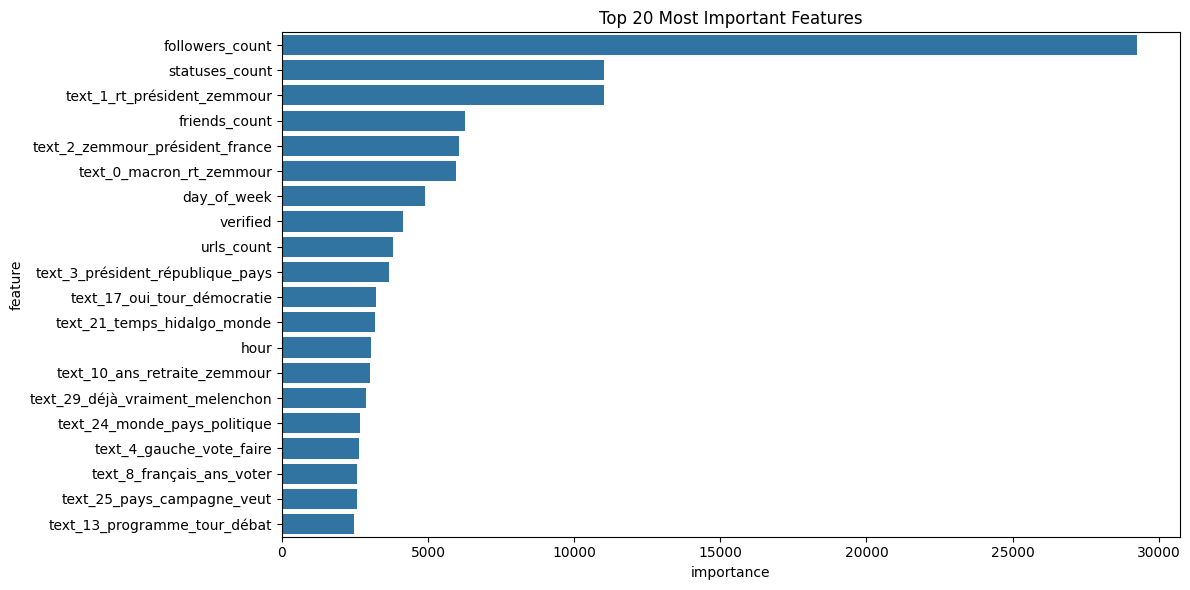

In [27]:
show_feature_importance(importances.to_numpy(), X)

#### 4. XGBoost

In [29]:
params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'device': ['cuda'],  # Enable GPU acceleration
        'predictor': ['gpu_predictor']
    }

xgb_model = tune_model(XGBRegressor(random_state=42, device='cuda', predictor='gpu_predictor'), params, X_train, y_train, "XGBoost", verbose=1)
xgb_pred = post_process_predictions(xgb_model.predict(X_test))
model_results['XGBoost'] = evaluate_model(y_test, xgb_pred, "XGBoost")


Tuning XGBoost...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:58:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'device': 'cuda', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'predictor': 'gpu_predictor'}

XGBoost Performance:
RMSE: 171.37
MAE: 8.74
R2 Score: 0.3808


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:58:55] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


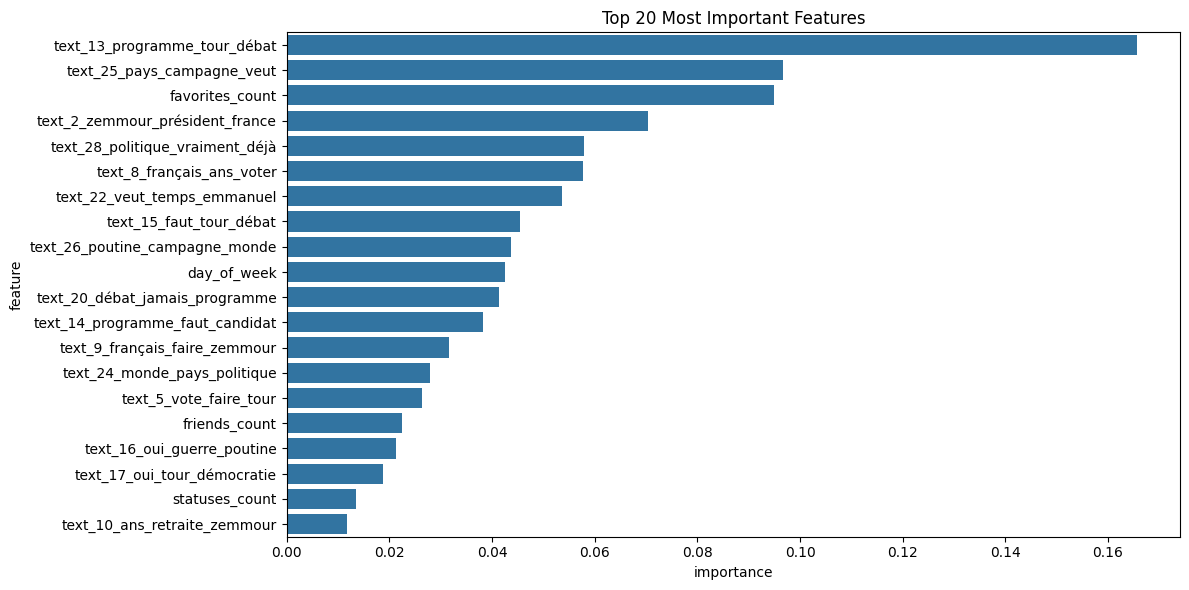

In [30]:
show_feature_importance(xgb_model.feature_importances_, X)

#### Compare the models

In [31]:
results_df = pd.DataFrame.from_dict(model_results, orient='index',
                                  columns=['RMSE', 'MAE', 'R2']).sort_values(by='RMSE')
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                         RMSE        MAE        R2
Linear Regression  133.824954  10.953004  0.622394
Ridge              133.824954  10.953004  0.622394
XGBoost            171.367575   8.735133  0.380812
Random Forest GPU  210.904752  25.711430  0.062140


### Create Ensemble Model

#### Importing Libraries

In [32]:
from sklearn.model_selection import KFold

#### 1. Weighted Average


In [33]:
def ensemble_predict_weighted(models, X, weights):
    predictions = np.column_stack([
        post_process_predictions(model.predict(X)) for model in models
    ])
    return np.average(predictions, axis=1, weights=weights)

In [34]:
best_models = [rf_model, xgb_model, ridge_model]
model_weights = [0.2, 0.3, 0.5]  # based on the performance of the models

ensemble_pred = ensemble_predict_weighted(best_models, X_test, model_weights)
evaluate_model(y_test, ensemble_pred, "Weighted Ensemble")



Weighted Ensemble Performance:
RMSE: 137.88
MAE: 11.46
R2 Score: 0.5992


(137.87677117425372, 11.460496652258666, 0.5991818906460182)

#### 2. Stacking


In [35]:
def create_stacking_features(models, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    stacking_features = np.zeros((X.shape[0], len(models)))

    for i, model in enumerate(models):
        print(f"Creating features for model {i+1}/{len(models)}")
        for train_idx, val_idx in kf.split(X):
            # Train on fold
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            # Predict on validation fold
            stacking_features[val_idx, i] = model.predict(X.iloc[val_idx]) # do not postprocess here, might have some additional info in real numbers

    return stacking_features

In [36]:
print("Creating stacking features...")
stacking_features_train = create_stacking_features(best_models, X_train, y_train)
stacking_features_test = np.column_stack([
    post_process_predictions(model.predict(X_test)) for model in best_models
])

Creating stacking features...
Creating features for model 1/3


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Creating features for model 2/3


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:59:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:59:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:59:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:59:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:59:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn

Creating features for model 3/3


In [37]:
stacking_df_test = pd.DataFrame(
    stacking_features_test,
    columns=['RF_predictions', 'XGBoost_predictions', 'Ridge_predictions']
)

print(stacking_df_test.head())

   RF_predictions  XGBoost_predictions  Ridge_predictions
0               2                    1                  5
1               5                    1                  5
2               5                    1                  0
3               1                    1                  0
4              21                    1                 14


In [38]:
# Train a meta-model (using Ridge as it performed well earlier)
meta_model = Ridge()
meta_model.fit(stacking_features_train, y_train)

stacking_predictions = post_process_predictions(meta_model.predict(stacking_features_test))

print("\nStacking Model Performance:")
evaluate_model(y_test, stacking_predictions, "Stacking Ensemble")

# Compare with individual model predictions
print("\nIndividual Model Performances on Test Set:")
for i, model_name in enumerate(['Random Forest', 'XGBoost', 'Ridge']):
    evaluate_model(y_test, stacking_features_test[:, i], model_name)


Stacking Model Performance:

Stacking Ensemble Performance:
RMSE: 129.68
MAE: 9.43
R2 Score: 0.6454

Individual Model Performances on Test Set:

Random Forest Performance:
RMSE: 211.03
MAE: 25.72
R2 Score: 0.0611

XGBoost Performance:
RMSE: 166.33
MAE: 8.69
R2 Score: 0.4167

Ridge Performance:
RMSE: 133.02
MAE: 11.83
R2 Score: 0.6269


### Save Models

In [39]:
import joblib
joblib.dump(meta_model, 'meta_model.pkl')
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(ridge_model, 'ridge_model.pkl')

['ridge_model.pkl']

### Predict on Eval Data

In [40]:
# Load the models
meta_model = joblib.load('meta_model.pkl')
rf_model = joblib.load('rf_model.pkl')
xgb_model = joblib.load('xgb_model.pkl')
ridge_model = joblib.load('ridge_model.pkl')

# preprocess evaluation data
eval = pd.read_csv('evaluation.csv')
X_eval = preprocess_data(eval, tfidf=tfidf, svd=svd, scaler=scaler, is_training=False) # reuse the same preprocessors
print(X_eval.shape)

# create stacking features
stacking_features_new_data = np.column_stack([
    model.predict(X_eval) for model in [rf_model, xgb_model, ridge_model] # also do not post process here, might have more info in real nums
])
new_predictions = post_process_predictions(meta_model.predict(stacking_features_new_data))

Preprocessing text...
Applying SVD...
(117990, 39)


### Save results in csv

In [41]:
new_predictions_df = pd.DataFrame({'retweets_count': new_predictions})
new_predictions_df.to_csv('new_predictions.csv', index=False)